# Solution to the exercise "Image deblurring", MIB Ch 5
"Use your camera to take an image with high resolution information, for example text.  Blur it with an Airy disk to simulate imaging though a microscope.  Corrupt that with additive noise to simulate limited photon counts.  Deconvolve.  First use a naive method, i.e. divide by the transfer function.  Then use regularized deconvolution as in Section 4.7.2.  Compare the results, for example by checking whether text is legible. You can also use a canned deblurring routine from your favorite programming language."

## Start with a simple image
Image = delta function.

Blur kernel = Gaussian.

Wiener deconvolution assumes flat power spectrum for both signal and noise, with a specified signal-to-noise power ratio.

Wiener kernel: 

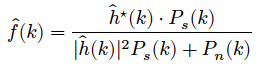

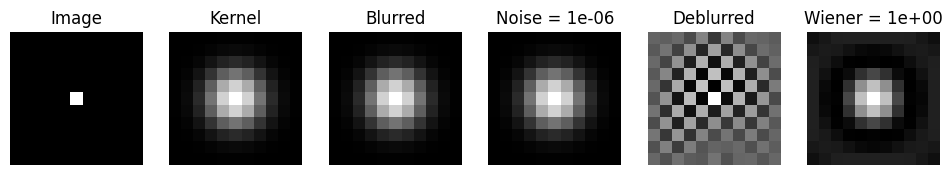

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.fftpack import fft2, ifft2

no = 1e-6 # noise level relative to max of blurred image
sn = 1 # signal-to-noise ratio assumed for Wiener deconvolution

x, y = np.meshgrid(np.arange(11),np.arange(11)) # 11x11 grid
img = (x-5)**2 + (y-5)**2 == 0 # delta function
ker_shift = np.exp(-((x-5)**2 + (y-5)**2)/5) # Gaussian kernel with origin in center of array
ker = np.roll(np.roll(ker_shift, -5, axis=0), -5, axis=1) # put origin of kernel at (0,0)
blu = ifft2(fft2(img) * fft2(ker)).real # blurred image; don't worry about edge effects, use circular convolution
noi = blu+no*np.max(blu) * np.random.randn(*blu.shape) # add noise

# Naive deconvolution
den = ifft2(fft2(noi) / fft2(ker)).real # deblurred image, just divide the fourier transforms

# Wiener deconvolution: assume both stimulus and noise spectra are white, with power ratio = sn
wie = (fft2(ker).conjugate() * sn) / (np.abs(fft2(ker))**2 * sn + 1) # wiener kernel fourier transform
dew = ifft2(wie * fft2(noi)).real # wiener filtered image

# plot everything
fig, ax = plt.subplots(1,6,figsize=(12, 4))
arr=[img,ker_shift,blu,noi,den,dew]
tit=['Image','Kernel','Blurred',f'Noise = {no}','Deblurred',f'Wiener = {sn:.0e}']
for i in range(len(ax)):
    ax[i].imshow(arr[i], cmap='gray'),ax[i].set_title(tit[i]),ax[i].axis('off')
plt.show()

## Use real image and Airy disk

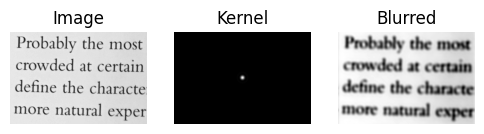

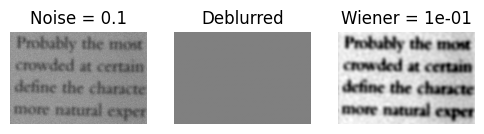

In [2]:
from skimage import color
from scipy.special import jv

ar = 5 # radius of Airy disk
no = 0.1
sn = 0.1 # signal-to-noise ratio assumed for Wiener deconvolution

# Load the image
img = plt.imread('Test_img.jpg')

# Convert the image to grayscale
img = color.rgb2gray(img)

# Compute the x- and y-coordinates for the image
x, y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))

# Origin in the middle of the image
yo, xo = np.array(img.shape) // 2

# Make the Airy disk kernel
r=np.sqrt((x-xo)**2+(y-yo)**2) # radius from origin
r[r==0]=1e-6 # avoids divide by zero
ker_shift = (jv(1, r/ar) / r) ** 2
ker = np.roll(np.roll(ker_shift, -yo, axis=0), -xo, axis=1) # put origin of kernel at (0,0)

# Make blurred image
blu = ifft2(fft2(img)*fft2(ker)).real # blurred image; don't worry about edge effects, use circular convolution

# Add noise
noi = blu + no * np.max(blu) * np.random.randn(*blu.shape) # add noise

# Naive deconvolution
den = ifft2(fft2(noi) / fft2(ker)).real # deblurred image, just divide the fourier transforms

# Wiener deconvolution: assume both stimulus and noise spectra are white, with power ratio = sn
wie = (fft2(ker).conjugate() * sn)/(np.abs(fft2(ker))**2 * sn + 1) # wiener kernel fourier transform
dew = ifft2(wie * fft2(noi)).real # wiener filtered image

# plot everything
arr=[img,ker_shift,blu,noi,den,dew]
tit=['Image','Kernel','Blurred',f'Noise = {no}','Deblurred',f'Wiener = {sn:.0e}']
fig, ax = plt.subplots(1,3,figsize=(6, 4))
for i in range(3):
    ax[i].imshow(arr[i], cmap='gray'),ax[i].set_title(tit[i]),ax[i].axis('off')
plt.show()
fig, ax = plt.subplots(1,3,figsize=(6, 4))
for i in range(3):
    ax[i].imshow(arr[i+3], cmap='gray'),ax[i].set_title(tit[i+3]),ax[i].axis('off')
plt.show()



### Results at various noise levels

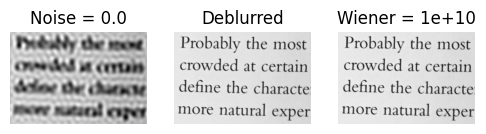

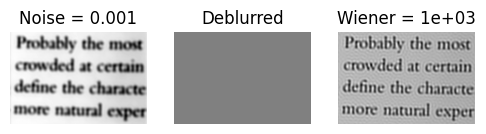

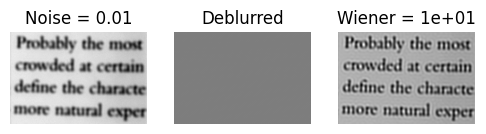

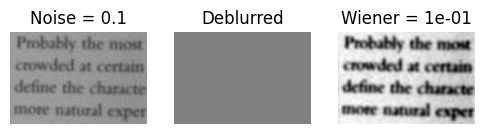

- Naive convolution fails for any level of noise above 0, because the noise is amplified by the deconvolution.
- Wiener deconvolution works well for low noise, with the appropriate choice of the SNR parameter. At high noise it just low-pass filters the image.
  